In [10]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import open3d as o3d
import os


In [13]:
def read_pointclouds(dir_path: Path, voxel_down_sample=0.1) -> o3d.geometry.PointCloud:
    assert dir_path.exists(), f"{dir_path} does not exist"
    # load the files
    pointcloud_folder = Path(dir_path)
    files = glob(pointcloud_folder.as_posix() + "/*.pcd")
    files.sort(key=os.path.getmtime)
    pcd = o3d.geometry.PointCloud()
    for file in tqdm(files):
        p = o3d.io.read_point_cloud(file)
        p_points = np.asarray(p.points)
        p_colors = np.asarray(p.colors)

        points = np.concatenate((np.asarray(pcd.points), p_points), axis=0)
        colors = np.concatenate((np.asarray(pcd.colors), p_colors), axis=0)

        pcd.points = o3d.utility.Vector3dVector(points)
        pcd.colors = o3d.utility.Vector3dVector(colors)

        pcd = pcd.voxel_down_sample(voxel_down_sample)
    return pcd

In [14]:
dir_path = Path("./data/pointcloud_1")
pcd = read_pointclouds(dir_path=dir_path)

100%|██████████| 686/686 [00:12<00:00, 57.01it/s]


In [70]:
from typing import Tuple, Optional
import open3d as o3d
import os
from glob import glob
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ROAR.utilities_module.data_structures_models import Location
from tqdm import tqdm


class Map:
    def __init__(self,
                 x_offset: float, y_offset: float, x_scale: float, y_scale: float,
                 x_width: int = 5000, y_height: int = 5000, buffer: int = 100,
                 name: str = "map"
                 ):
        self.name = name
        self.x_offset = x_offset
        self.y_offset = y_offset
        self.x_scale = x_scale
        self.y_scale = y_scale
        self.x_width = x_width
        self.y_height = y_height
        self.buffer = buffer
        self.map = np.zeros(shape=(self.y_height, self.x_width))

    def project_free_points_with_height(self, pcd: o3d.geometry.PointCloud):
        print(f"Projecting {pcd} with their height as value onto current map")
        points = np.asarray(pcd.points)
        for point in tqdm(points):
            occu_coord = self.world_loc_to_occu_map_coord(Location.from_array(point))
            val = point[1]
            self.map[occu_coord[1]][occu_coord[0]] = val

    def smooth_map(self, kernel_size=5):
        kernel = np.ones((kernel_size,kernel_size), np.uint8)
        self.map = cv2.erode(cv2.dilate(self.map, kernel, iterations=1), kernel, iterations=1)

    def world_loc_to_occu_map_coord(self, loc: Location) -> Tuple[int, int]:
        """
        Takes in a coordinate in the world reference frame and transform it into the occupancy map coordinate by
        applying the equation
        `int( (WORLD + OFFSET ) * SCALE)`

        Args:
            loc:

        Returns:

        """
        x = int((loc.x + self.x_offset) * self.x_scale) + self.buffer
        y = int((loc.z + self.y_offset) * self.y_scale) + self.buffer
        return x, y

    def world_arr_to_occu_map(self, arr: np.ndarray) -> np.ndarray:
        xs = ((arr[:, 0] + self.x_offset) * self.x_scale + self.buffer).astype(int)
        ys = ((arr[:, 1] + self.y_offset) * self.y_scale + self.buffer).astype(int)
        return np.array([xs, ys]).T

    def occu_map_to_world(self, point: Tuple[int, int]) -> Tuple[float, float]:
        x, y = point
        X = (x - self.buffer) / self.x_scale - self.x_offset
        Y = (y - self.buffer) / self.y_scale - self.y_offset
        return X, Y

    def get_all_obstacles_in_world(self, threshold=0.5) -> Tuple[np.ndarray, np.ndarray]:
        xs, ys = np.where(self.map > threshold)
        return (xs - self.buffer) / self.x_scale - self.x_offset, (ys - self.buffer) / self.y_scale - self.y_offset

    def pcd_to_occu_map(self, pcd: o3d.geometry.PointCloud):
        points = np.asarray(pcd.points)
        xs = np.expand_dims(points[:, 0], axis=1)
        zs = np.expand_dims(points[:, 2], axis=1)
        arr = np.hstack([xs, zs])
        return self.world_arr_to_occu_map(arr)

    @staticmethod
    def extract_xz_points_from_pcd(pcd: o3d.geometry.PointCloud) -> np.ndarray:
        points = np.asarray(pcd.points)
        xs = np.expand_dims(points[:, 0], axis=1)
        zs = np.expand_dims(points[:, 2], axis=1)
        points = np.hstack([xs, zs])
        return points

    def update(self, points: np.ndarray, val=1) -> int:
        """

        Args:
            val: value to update those points to
            points: points is a 2D numpy array consist of X and Z coordinates

        Returns:
            number of points updated
        """
        points = self.world_arr_to_occu_map(points)
        self.map[points[:, 1], points[:, 0]] = val
        return len(points)

    def visualize(self, dsize: Optional[Tuple] = None):
        img = self.map.copy()
        if dsize:
            img = cv2.resize(img, dsize=dsize)
        plt.imshow(img, cmap='gray')
        plt.show()
        # cv2.imshow(self.name, img)

    @staticmethod
    def moving_average(a, n=3):
        ret_x = np.cumsum(a[:, 0], dtype=float)
        ret_z = np.cumsum(a[:, 1], dtype=float)

        ret_x[n:] = ret_x[n:] - ret_x[:-n]
        ret_z[n:] = ret_z[n:] - ret_z[:-n]

        ret_x = ret_x[n - 1:] / n
        ret_z = ret_z[n - 1:] / n

        return np.array([ret_x, ret_z]).T

    @staticmethod
    def find_hyperparam_from_pcd(pcd: o3d.geometry.PointCloud, scale, buffer):
        x_offset = np.max([abs(np.floor(pcd.get_min_bound()[0])), abs(np.ceil(pcd.get_max_bound()[0]))]).astype(int)
        y_offset = np.max([abs(np.floor(pcd.get_min_bound()[2])), abs(np.ceil(pcd.get_max_bound()[2]))]).astype(int)
        x_width = np.ceil((pcd.get_max_bound()[0] + x_offset) * scale + buffer).astype(int)
        y_height = np.ceil((pcd.get_max_bound()[2] + y_offset) * scale + buffer).astype(int)
        return x_offset, y_offset, x_width, y_height

    @staticmethod
    def read_pointclouds(dir_path: Path, voxel_down_sample=0.1) -> o3d.geometry.PointCloud:
        assert dir_path.exists(), f"{dir_path} does not exist"
        # load the files
        pointcloud_folder = Path(dir_path)
        files = glob(pointcloud_folder.as_posix() + "/*.pcd")
        files.sort(key=os.path.getmtime)
        pcd = o3d.geometry.PointCloud()
        for file in tqdm(files):
            p = o3d.io.read_point_cloud(file)
            p_points = np.asarray(p.points)
            p_colors = np.asarray(p.colors)

            points = np.concatenate((np.asarray(pcd.points), p_points), axis=0)
            colors = np.concatenate((np.asarray(pcd.colors), p_colors), axis=0)

            pcd.points = o3d.utility.Vector3dVector(points)
            pcd.colors = o3d.utility.Vector3dVector(colors)

            pcd = pcd.voxel_down_sample(voxel_down_sample)
        return pcd

In [78]:
scale = 15
buffer = 0
x_offset, y_offset, x_width, y_height = Map.find_hyperparam_from_pcd(pcd=pcd, scale=scale, buffer=buffer)
map_with_height = Map(
    x_offset=x_offset, y_offset=y_offset, x_scale=scale, y_scale=scale,
    x_width=x_width, y_height=y_height, buffer=buffer, name="map_with_height"
)

occu_map = Map(
    x_offset=x_offset, y_offset=y_offset, x_scale=scale, y_scale=scale,
    x_width=x_width, y_height=y_height, buffer=buffer, name="occu_map"
)
skeleton_map = Map(
    x_offset=x_offset, y_offset=y_offset, x_scale=scale, y_scale=scale,
    x_width=x_width, y_height=y_height, buffer=buffer, name="skeleton_map"
)

In [79]:
map_with_height.project_free_points_with_height(pcd)
occu_map.update(Map.extract_xz_points_from_pcd(pcd=pcd))
occu_map.smooth_map(5)

Projecting PointCloud with 131855 points. with their height as value onto current map


100%|██████████| 131855/131855 [00:00<00:00, 176740.28it/s]


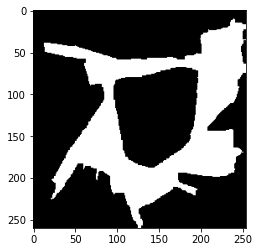

In [80]:
plt.imshow(occu_map.map, cmap='gray')

In [397]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

In [398]:
nav_map = np.zeros(shape=(skeleton_map.map.shape[0], skeleton_map.map.shape[1], 3),
                   dtype=np.uint8)
nav_map[np.where(skeleton_map.map > 0.5)] = np.array([255, 255, 255]).astype(np.uint8)

In [399]:
# perform skeletonization
skeleton_map.map = skeletonize(occu_map.map)
skeleton_map.map = skeleton_map.map.astype(float)
skeleton_map.smooth_map(2)

In [400]:
def find_closest_on_map(data, coord):
    all_waypoint_coords = np.vstack(np.where(data == 1))
    dist = np.linalg.norm(all_waypoint_coords - coord, axis=0)
    min_index = np.argmin(dist)
    min_coord =  all_waypoint_coords[:, min_index]
    return min_coord

In [401]:
start_loc:Location = Location.from_array(np.array([-1.1319398,0.02977551,0.3790202]))
end_loc: Location = Location.from_array(np.array([-7.5140696,-0.04548472,-2.4632778]))

start_coord = np.expand_dims(np.array(skeleton_map.world_loc_to_occu_map_coord(start_loc))[::-1], 1)
end_coord = np.expand_dims(np.array(skeleton_map.world_loc_to_occu_map_coord(end_loc))[::-1], 1)

# find the closest point to start coord in skeleton map
start_coord = find_closest_on_map(skeleton_map.map, start_coord)
end_coord = np.array([start_coord[0]+1, start_coord[1]])

In [402]:
nav_map[start_coord[0] - 2: start_coord[0] + 2, start_coord[1]-2:start_coord[1]+2] = [255,0,0]
nav_map[end_coord[0]-2:end_coord[0]+2, end_coord[1]-2:end_coord[1]+2] = [0,0,255]


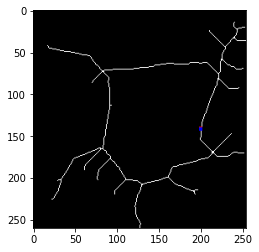

In [403]:
plt.imshow(nav_map)

In [404]:
# do DFS until I've repeated at the start location
motions = np.array([[-1, 0],[0, -1],[-1, -1],[-1, 1],[1, -1],[1, 1],[1, 0],[0, 1]]).astype(int)
visited = set()
to_visit = [] # nodes to visit

current_node = (start_coord[0], start_coord[1])
end_node = (end_coord[0], end_coord[1])
visited.add(current_node)



In [405]:
def dfs(node, target, path, visited=set()):
    path.append(node)
    visited.add(node)
    if node == target:
        return path
    for motion in motions:
        x, y = node+motion
        if 0<=x<skeleton_map.map.shape[0] and 0<=y<skeleton_map.map.shape[1] and skeleton_map.map[x][y] == 1 and (x, y) not in visited:
            result = dfs(node=(x, y), target=target, path=path, visited=visited)
            if result is not None:
                return result
            path.pop()
    return None


In [406]:
path = []
path = dfs(node=current_node, target=end_node, path=path, visited=set())

In [407]:
for coord in path:
    nav_map[coord[0]][coord[1]] = [0,255,0]

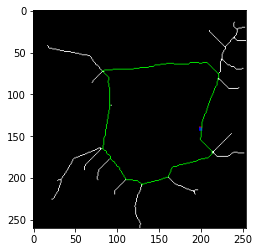

In [408]:
plt.imshow(nav_map)

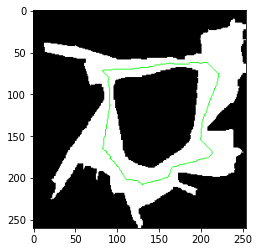

In [409]:
nav_map = np.zeros(shape=(skeleton_map.map.shape[0], skeleton_map.map.shape[1], 3),
                   dtype=np.uint8)
nav_map[np.where(occu_map.map > 0.5)] = np.array([255, 255, 255]).astype(np.uint8)
for coord in path:
    nav_map[coord[0]][coord[1]] = [0,255,0]
plt.imshow(nav_map)